# 目的

我的crf出现 loss 从 > 0到 小于0

问题是loss一般不会小于0

## 问题解决

原因是sum of path最后对z求和的时候使用sum而不是logsumexp

#### set up

In [1]:
#export
import sys
if __name__ == '__main__': sys.path.append('..')
import exp.common as common
from pprint import pprint
def pj(*args, **kargs):
    if common.IN_JUPYTER:
        pprint(*args, **kargs)

In [2]:
#test_export
import sure

In [3]:
#export
import torch
from torch import optim
from exp.CRF import CRF
from exp.CRF import onehot
import numpy as np
num_label = 3
inputs = np.array([
    # seq
    [
        [0.1, 0.2, 0.1],
        [0.1, 0.2, 0.3],
    ]
])
LABELS = np.array([
    [1,1]
])
labels = onehot(LABELS, 3)
(inputs, labels, ) = map(torch.Tensor,  (inputs, labels, ) )
(LABELS, ) = map(torch.LongTensor, (LABELS, ))
MASK = torch.ones_like(LABELS, dtype=torch.bool)

In [4]:
#export
# 没有提前取负号
from torch import nn
from lib.ConditionalRandomField import ConditionalRandomField, allowed_transitions
label_dic = {'O':0, 'B-a':1, 'I-a':2}
constraints = allowed_transitions(constraint_type='BIO', labels=label_dic)

class J_crf(nn.Module):
    def __init__(self):
        super().__init__()
        self.crf = ConditionalRandomField(num_tags=len(label_dic), constraints=constraints, include_start_end_transitions=False)
    
    def forward(self, inputs, labels):
        return -self.crf(inputs, labels)

In [5]:
#export
import matplotlib.pyplot as plt
def pxy(x, y, name='idk'):
    name = str(name)
    fig, = plt.plot(x,y, )
    fig.set_label(name)
    plt.legend()
# pxy([1,2], [3,2], '2')
# pxy([1,2], [5,6], '1')

#### my crf

###### 我的crf

In [6]:
#test_export
# (路劲分数/配分函数) < 1
# log(路劲分数/配分函数) < 0
# -log(路劲分数/配分函数) > 0
crf = CRF(num_label)
args = (inputs, labels)
loss = crf(inputs, labels)
assert torch.all(loss > 0)

In [7]:
#test_export
sop = crf._sum_over_path_score(*args).sum()
ps = crf._path_score(*args).sum()
# loss == spo - ps
# sum of path 应该  > path score
# 看了一边代码感觉没问题
# 看了一下trans的初始化，有点区别，感觉没啥问题，都是有正有负，不过j的variance要大一些
assert sop > ps, "sum of path 应该  > path score"
del crf

##### 借用trans，对比分数

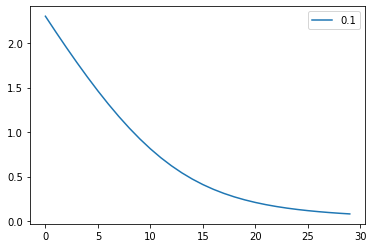

In [8]:
#test_export
j_crf = J_crf()
lr=1e-1
op1 = optim.Adam(j_crf.parameters(), lr=lr)
y=[]
x=[]
for i in range(30):
    op1.zero_grad()
    loss = j_crf(inputs, LABELS)
    x.append(i) 
    y.append(loss.detach().numpy())
    loss.backward()
    op1.step()
pxy(x,y, lr)

In [9]:
#test_export
del j_crf

In [10]:
#test_export
# 借用一下j_crf的tran矩阵
# 同时检验两个path score, 和 sum of path score
# crf.trans
crf = CRF(num_label)
j_crf = J_crf()
j_crf.crf.transitions = nn.Parameter(torch.ones(3,3))
crf.trans = nn.Parameter(j_crf.crf.transitions)

In [11]:
#test_export
sop = crf._sum_over_path_score(*args)
ps = crf._path_score(*args)
# loss == spo - ps
# print(sop, ps,  sop - ps, 'should >0')
print(ps)
# assert sop > ps, "sum of path 应该  > path score"

tensor([[1.4000]], grad_fn=<AddBackward0>)


In [12]:
#test_export
# path score
# 注意这里给LABELS，和我的不一样，否则会出现batch_size不一致的问题
assert torch.allclose(ps,j_crf.crf._joint_likelihood(inputs, LABELS, MASK) )
j_crf.crf._joint_likelihood(inputs, LABELS, MASK)

tensor([1.4000], grad_fn=<AddBackward0>)

In [13]:
#test_export
j_crf.crf._input_likelihood(inputs, MASK), sop
assert torch.allclose(j_crf.crf._input_likelihood(inputs, MASK), sop)

In [14]:
# 试试trans初始值的设置？

##### 我的收敛能力

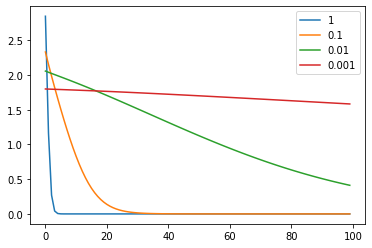

In [15]:
#test_export
from torch.optim.lr_scheduler import CosineAnnealingLR
from functools import partial

tmp = J_crf()

get_model = partial(CRF, num_label)
# get_model, model, op, lr
for lr in (1, 1e-1, 1e-2, 1e-3):
    model = get_model()
    
    op = optim.Adam(model.parameters(), lr=lr)
    y=[]
    x=[]
    for i in range(100):
        op1.zero_grad()
        loss = model(inputs, labels)
        x.append(i) 
        y.append(loss.detach().numpy())
        loss.backward()
        op.step()
    pxy(x,y, lr)

del get_model, model, op, lr

####  对比zxj crf

In [16]:
#test_export
j_crf = J_crf()
op1 = optim.Adam(j_crf.parameters(), lr=1e-2)
with torch.no_grad():
    print(j_crf(inputs, LABELS), j_crf.crf.transitions)

tensor(2.7601) Parameter containing:
tensor([[-0.2597, -0.8832, -0.7137],
        [ 1.1981, -0.2270,  0.6111],
        [ 0.3066,  0.2147,  1.1089]], requires_grad=True)


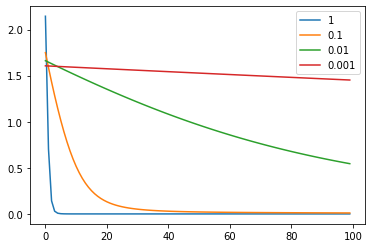

In [17]:
#test_export
for lr in (1, 1e-1, 1e-2, 1e-3):
    j_crf = J_crf()
    op1 = optim.Adam(j_crf.parameters(), lr=lr)
    y=[]
    x=[]
    for i in range(100):
        op1.zero_grad()
        loss = j_crf(inputs, LABELS)
        x.append(i) 
        y.append(loss.detach().numpy())
        loss.backward()
        op1.step()
    pxy(x,y, lr)
    del j_crf

In [18]:
# 结论正常

#### 测试viterbi

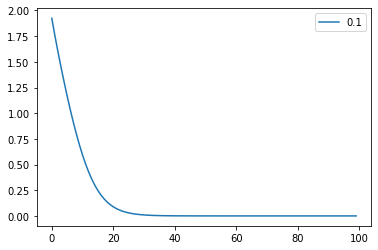

In [19]:
#test_export
from exp.CRF import j_viterbi as viterbi
from functools import partial

get_model = partial(CRF, num_label)
model = get_model()

lr = 1e-1
op = optim.Adam(model.parameters(), lr=lr)
y=[]
x=[]
for i in range(100):
    op1.zero_grad()
    loss = model(inputs, labels)
    x.append(i) 
    y.append(loss.detach().numpy())
    loss.backward()
    op.step()
pxy(x,y, lr)

with torch.no_grad():
    a = viterbi(inputs, model.trans) 

assert torch.allclose(torch.LongTensor(a), LABELS)
del get_model, model, op, lr, a

In [ ]:
common.save_and_export_notebook('basic_test_for_crf')

<IPython.core.display.Javascript object>

Converted basic_test_for_crf.ipynb to ..\exp\basic_test_for_crf.py
Converted basic_test_for_crf.ipynb to ..\test\test_basic_test_for_crf.py
